In [277]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

In [278]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,XLU.Low,XLU.Close,XLU.Volume,XLU.Adjusted,XLRE.Open,XLRE.High,XLRE.Low,XLRE.Close,XLRE.Volume,XLRE.Adjusted
994,2010-12-13,54.700001,54.740002,54.270000,54.299999,53110200,49.576870,31.639999,31.770000,30.400000,...,31.150000,31.270000,6372800,22.903078,0,0,0,0,0,0
995,2010-12-14,54.439999,54.619999,54.230000,54.400002,69884800,49.668179,30.290001,30.389999,27.760000,...,31.280001,31.350000,5067000,22.961678,0,0,0,0,0,0
996,2010-12-15,54.369999,54.700001,54.029999,54.160000,76951900,49.449055,28.670000,29.969999,28.530001,...,31.070000,31.080000,10642900,22.763918,0,0,0,0,0,0
997,2010-12-16,54.209999,54.660000,54.060001,54.580002,65519400,49.832520,30.000000,30.910000,29.650000,...,30.959999,31.360001,5598800,22.969000,0,0,0,0,0,0
998,2010-12-17,54.540001,54.680000,54.410000,54.520000,36844200,49.876442,31.340000,31.540001,30.709999,...,30.820000,31.150000,6159100,23.088327,0,0,0,0,0,0


In [205]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [273]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Thoughts
FEDFUNDS = df_from_fred("FEDFUNDS")
time.sleep(5)
UNRATE = df_from_fred("UNRATE")
time.sleep(5)
T10Y2Y = df_from_fred("T10Y2Y")
time.sleep(5)
CBBTCUSD = df_from_fred("CBBTCUSD")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")

# IPMAN, MPU9900063, PCU33443344, MEHOINUSA672N, TCMDO, FGTCMDODNS, ADSLFAA027N, NCBCMDPMVCE, FGCCSAQ027S, ASTNITA

In [279]:
data_orig = data_orig\
  .merge(GDPC1, how="left", left_on=data_orig.Index, right_on=GDPC1.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(M2, how="left", left_on=data_orig.Index, right_on=M2.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CPALTT01USQ657N, how="left", left_on=data_orig.Index, right_on=CPALTT01USQ657N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PPIACO, how="left", left_on=data_orig.Index, right_on=PPIACO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UMCSENT, how="left", left_on=data_orig.Index, right_on=UMCSENT.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PAYEMS, how="left", left_on=data_orig.Index, right_on=PAYEMS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(RRSFS, how="left", left_on=data_orig.Index, right_on=RRSFS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(HOUST, how="left", left_on=data_orig.Index, right_on=HOUST.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ISRATIO, how="left", left_on=data_orig.Index, right_on=ISRATIO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCETRIM12M159SFRBDAL, how="left", left_on=data_orig.Index, right_on=PCETRIM12M159SFRBDAL.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ASTNITA, how="left", left_on=data_orig.Index, right_on=ASTNITA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGCCSAQ027S, how="left", left_on=data_orig.Index, right_on=FGCCSAQ027S.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(NCBCMDPMVCE, how="left", left_on=data_orig.Index, right_on=NCBCMDPMVCE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ADSLFAA027N, how="left", left_on=data_orig.Index, right_on=ADSLFAA027N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGTCMDODNS, how="left", left_on=data_orig.Index, right_on=FGTCMDODNS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TCMDO, how="left", left_on=data_orig.Index, right_on=TCMDO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MEHOINUSA672N, how="left", left_on=data_orig.Index, right_on=MEHOINUSA672N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCU33443344, how="left", left_on=data_orig.Index, right_on=PCU33443344.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MPU9900063, how="left", left_on=data_orig.Index, right_on=MPU9900063.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IPMAN, how="left", left_on=data_orig.Index, right_on=IPMAN.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SP500, how="left", left_on=data_orig.Index, right_on=SP500.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FEDFUNDS, how="left", left_on=data_orig.Index, right_on=FEDFUNDS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UNRATE, how="left", left_on=data_orig.Index, right_on=UNRATE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(T10Y2Y, how="left", left_on=data_orig.Index, right_on=T10Y2Y.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CBBTCUSD, how="left", left_on=data_orig.Index, right_on=CBBTCUSD.DATE).fillna(method="ffill")\
  .fillna(-1)

In [280]:
data_orig.drop(['DATE_y', 'DATE_x', 'key_0', 'DATE'], axis=1, inplace=True)

In [281]:
list(data_orig.columns)

['Index',
 'QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 '

In [282]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if 'Open' in i[1]])
ticker_lookup

{'AAPL': 25,
 'AMD': 73,
 'AMZN': 37,
 'BABA': 205,
 'BP': 211,
 'BUD': 217,
 'DATA': 67,
 'DIS': 151,
 'DUK': 163,
 'FB': 43,
 'GLD': 181,
 'GLW': 223,
 'GOOG': 49,
 'HD': 157,
 'INTC': 19,
 'JNJ': 109,
 'JWN': 97,
 'KO': 115,
 'MSFT': 13,
 'NFLX': 31,
 'NVDA': 133,
 'PANW': 127,
 'PFE': 229,
 'PG': 103,
 'QQQ': 1,
 'RHT': 139,
 'RYSDX': 199,
 'SBUX': 79,
 'SFIX': 235,
 'SLV': 187,
 'SPOT': 169,
 'SQ': 55,
 'STX': 241,
 'T': 247,
 'TGT': 91,
 'TNX': 193,
 'TSLA': 7,
 'TWTR': 61,
 'USO': 145,
 'V': 253,
 'VRSN': 121,
 'WDC': 175,
 'WMT': 85,
 'XLB': 265,
 'XLE': 259,
 'XLF': 295,
 'XLI': 271,
 'XLK': 301,
 'XLP': 283,
 'XLRE': 319,
 'XLU': 313,
 'XLV': 289,
 'XLY': 277,
 'XTL': 307}

In [283]:
CHOSENTICKER = 'QQQ'

In [284]:
days_lookback = 1
theta = 0.05 # This needs to go between pct_change and argmax apply
# This looks for which 1 stock will have the greatest rise on any given day
pct_df = data_orig.iloc[:,list(ticker_lookup.values())].pct_change(days_lookback).apply(lambda y: y.argmax(), axis=1).fillna("QQQ.Open")

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


In [285]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
pct_df.map(lambda x: inv_map[x])

0       0
1      16
2      37
3      24
4      41
5       4
6      22
7      37
8      22
9       4
10     24
11     15
12     20
13     31
14     37
15      5
16     23
17     40
18     13
19     24
20     16
21     20
22     24
23     22
24     37
25      5
26     23
27     30
28     23
29     16
       ..
969     1
970    31
971    31
972     2
973     1
974    22
975     1
976     1
977    15
978    36
979     6
980     5
981     1
982     1
983     6
984     5
985    31
986     1
987    23
988    26
989    40
990     5
991     1
992    26
993     5
994    31
995    35
996    33
997     1
998     1
Length: 999, dtype: int64

In [286]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig.iloc[:,1:])

scaler = MinMaxScaler(feature_range=(0, 1))
# data_mat = scaler.fit_transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig_detrended)

In [287]:
seq_len = 360 # days to use for prediction
data = np.array((data_mat))

In [288]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [289]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = to_categorical(pct_df.map(lambda x: inv_map[x]))[:int(row)]
x_test = result[int(row):, :]
y_test = to_categorical(pct_df.map(lambda x: inv_map[x]))[int(row):]

[x_train, y_train, x_test, y_test]

[array([[[0.59492521, 0.59506453, 0.59520475, ..., 0.83722872,
          0.83634135, 0.83545961],
         [0.71346882, 0.71355332, 0.71363834, ..., 0.78521557,
          0.7838429 , 0.78247895],
         [0.73346978, 0.73354771, 0.7336262 , ..., 0.77782396,
          0.77636897, 0.77492322],
         ...,
         [0.74048371, 0.74028143, 0.74007779, ..., 0.63437295,
          0.63293356, 0.63150341],
         [0.66703333, 0.66673952, 0.66644377, ..., 0.60301342,
          0.60189495, 0.60078368],
         [0.54269583, 0.54259204, 0.54248761, ..., 0.72472015,
          0.72408934, 0.72346263]],
 
        [[0.71346882, 0.71355332, 0.71363834, ..., 0.78521557,
          0.7838429 , 0.78247895],
         [0.73346978, 0.73354771, 0.7336262 , ..., 0.77782396,
          0.77636897, 0.77492322],
         [0.77018765, 0.7702533 , 0.77031942, ..., 0.76409532,
          0.76248926, 0.76089339],
         ...,
         [0.66703333, 0.66673952, 0.66644377, ..., 0.60301342,
          0.60189495, 0.

In [290]:
LAYERS = 150
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(
    output_dim=y_train.shape[1]))
model.add(Activation('sigmoid'))

start = time.time()
rmsprop = RMSprop(lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop)
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 349..., units=150)`
  import sys


compilation time :  0.02852010726928711


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=53)`
  app.launch_new_instance()


In [291]:
MODELNAME = 'multiplemodeltest_withoutTrend5'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [307]:
VALIDATIONSIZE = 0.25
EPOCHS = 500
model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save],
    shuffle=True)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 430 samples, validate on 144 samples
Epoch 1/500
430/430 [==============================] - 21s 49ms/step - loss: 3.5494 - val_loss: 3.8045
Epoch 2/500
430/430 [==============================] - 13s 31ms/step - loss: 3.5660 - val_loss: 3.8990
Epoch 3/500
430/430 [==============================] - 13s 29ms/step - loss: 3.5879 - val_loss: 3.6508
Epoch 4/500
430/430 [==============================] - 12s 29ms/step - loss: 3.5039 - val_loss: 3.6333
Epoch 5/500
430/430 [==============================] - 12s 28ms/step - loss: 3.5531 - val_loss: 3.5777
Epoch 6/500
430/430 [==============================] - 13s 30ms/step - loss: 3.4850 - val_loss: 3.5529
Epoch 7/500
430/430 [==============================] - 13s 29ms/step - loss: 3.5491 - val_loss: 3.5445
Epoch 8/500
430/430 [==============================] - 13s 29ms/step - loss: 3.5453 - val_loss: 3.5767
Epoch 9/500
430/430 [==============================] - 12s 28ms/step - loss: 3.4604 - val_loss: 3.6704
Epoch 10/500
430/430 [=====

In [322]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [321]:
from sklearn import metrics
metrics.confusion_matrix([np.array([1 if w >= 0.5 else 0 for w in i]) for i in best_model.predict(x_test)], y_test)

ValueError: Found input variables with inconsistent numbers of samples: [64, 425]

In [323]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

In [324]:
from collections import defaultdict
dd = defaultdict(list)
qq = defaultdict(list)
for d in range(days):
    li = []
    for k in sorted(zip(list(ticker_lookup.keys()), best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[d]), key = lambda x: x[1], reverse=True):
        dd[k[0]].append(k[1])
        li.append(k[0])
    qq[d] = li

In [325]:
dd

defaultdict(list,
            {'AAPL': [0.9732708,
              0.97322774,
              0.97321856,
              0.97211987,
              0.97321385],
             'AMD': [0.965247, 0.965234, 0.9652564, 0.9627485, 0.96529436],
             'AMZN': [0.9988299, 0.998838, 0.9988417, 0.99883574, 0.9988457],
             'BABA': [0.009147818,
              0.009172482,
              0.009177272,
              0.00980571,
              0.009179154],
             'BP': [0.1396555, 0.13820976, 0.13766916, 0.12754896, 0.13715132],
             'BUD': [0.009058299,
              0.009073493,
              0.009073039,
              0.009744549,
              0.009068885],
             'DATA': [0.008026028,
              0.008011615,
              0.007999944,
              0.008368914,
              0.007984991],
             'DIS': [0.055456087,
              0.05521542,
              0.055095952,
              0.0545459,
              0.05496361],
             'DUK': [0.023979371,
       

In [327]:
[qq[i][:10] for i in range(days)]

[['AMZN', 'STX', 'WDC', 'NFLX', 'GLD', 'NVDA', 'USO', 'SBUX', 'RYSDX', 'JWN'],
 ['AMZN', 'STX', 'WDC', 'NFLX', 'GLD', 'NVDA', 'USO', 'SBUX', 'RYSDX', 'JWN'],
 ['AMZN', 'STX', 'WDC', 'NFLX', 'GLD', 'NVDA', 'USO', 'SBUX', 'RYSDX', 'JWN'],
 ['AMZN', 'STX', 'WDC', 'NFLX', 'GLD', 'NVDA', 'USO', 'SBUX', 'JWN', 'RYSDX'],
 ['AMZN', 'STX', 'WDC', 'NFLX', 'GLD', 'NVDA', 'USO', 'SBUX', 'RYSDX', 'JWN']]

In [328]:
lookup_map = {v:k for k, v in inv_map.items()}
# model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[0].argmax()
[lookup_map[best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[i].argmax()] for i in range(5)]

['AMZN.Open', 'AMZN.Open', 'AMZN.Open', 'AMZN.Open', 'AMZN.Open']

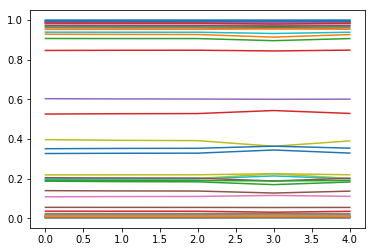

In [329]:
plt.plot([k for k in best_model.predict(np.reshape(data[-5:], (5, 1, data.shape[1])))])
plt.show()